In [1]:
import sys
sys.path.append('../')
from data_loader import DataLoader
import random
from feature_selector import BaselineSelector
from feature_selector import FeatureExtractor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [2]:
# file path to our dataset to all epoches of all participants
data_path = "../data/dataset"

# create a data loader for all participants
par_loaders = [0] * 88
for i in range(88):
    par_loaders[i] = DataLoader(data_path, [i])

# returns all data of all epochs for participant one 
participants = par_loaders[0][:]
# returns data of the first epoch for participant one for all channels
participant1 = participants[0]['data']

In [34]:
selector1 = BaselineSelector()
selector1.selectFeatures(['kurtosis'])

channel_means_A = {}
channel_means_C = {}
channel_means_F = {}
for channel in range(19):
    channel_means_A[channel] = []
    channel_means_C[channel] = []
    channel_means_F[channel] = []

In [35]:
for participant in par_loaders:
    x = {}
    for channel in range(19):
        x[channel] = []
    
    for epoch in participant[:]:
        epoch_data = epoch['data']
        out1 = selector1.transform(epoch_data)
        for channel in range(19):
            x[channel].append(out1[channel])
    for channel in range(19):
        if participant[0]['group'] == 'A':
            channel_means_A[channel].append(scipy.stats.kurtosis(x[channel]))
        elif participant[0]['group'] == 'C':
            channel_means_C[channel].append(scipy.stats.kurtosis(x[channel]))
        elif participant[0]['group'] == 'F':
            channel_means_F[channel].append(scipy.stats.kurtosis(x[channel]))
    

In [44]:
channel_means_A_df = pd.DataFrame(channel_means_A)
channel_means_C_df = pd.DataFrame(channel_means_C)
channel_means_F_df = pd.DataFrame(channel_means_F)

In [85]:
ch = 17
data_ch = {}
data_ch = pd.DataFrame({'A': channel_means_A_df[ch], 'C': channel_means_C_df[ch], 'F': channel_means_F_df[ch]})

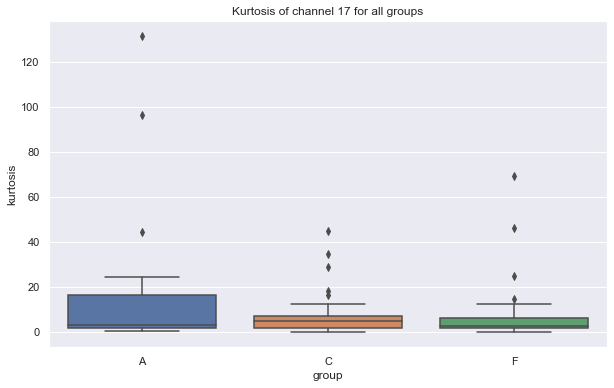

In [86]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set(style="darkgrid")
ax = sns.boxplot(data = data_ch)
ax.set(xlabel='group', ylabel='kurtosis', title='Kurtosis of channel '+str(ch)+' for all groups')
plt.show()